## Description

In this notebook, we estimate the concentrations of lipid ions in pixels of our MS images.  
We use lipid ions detected in Notebook 3.  
We compare the resulting spatial distributions with single ion images of the same lipids (i.e. the spatial distributions of peak intensities of the lipids, taken from unprocessed MS images).   

## Data & modules

In [2]:
%matplotlib notebook

In [3]:
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from time import time
import pandas as pd
from sklearn.cluster import KMeans
from additional_functions import profile_ion_image, centroided_ion_image, segment_average_spectra, analyze_image

In [4]:
import numpy.random as rd

In [5]:
analyzed_mass_range = (700, 900)

In [6]:
cerebellum_image_shape = (21, 81)
bladder_image_shape = (134, 260)

In [7]:
bladder_centroided_image = ImzMLParser('MSimages/bladder_centroided.imzML')
cerebellum_centroided_image = ImzMLParser('MSimages/cerebellum_centroided.imzML')

In [8]:
bladder_profile_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
cerebellum_profile_image = ImzMLParser('MSimages/test_POS.imzML')

/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000584 found with incorrect name "mz

In [9]:
centroided_images = {'cerebellum': cerebellum_centroided_image, 
                     'bladder': bladder_centroided_image}
profile_images = {'cerebellum': cerebellum_profile_image, 
                  'bladder': bladder_profile_image}
image_shapes = {'cerebellum': cerebellum_image_shape, 
                'bladder': bladder_image_shape}
image_names = ['cerebellum', 'bladder']

In [10]:
average_spectra = {}
average_spectrum_masses = {}
for i, n in enumerate(image_names):
    sp = open(n + '_centroided_average_spectrum.tsv')
    next(sp) # skipping the header
    sp = [l.strip().split('\t') for l in sp]
    sp = [(float(mz), float(intsy)) for mz, intsy in sp]
    sp = Spectrum(confs=sp)
    sp.normalize()
    average_spectra[n] = sp
    average_spectrum_masses[n] = [x[0] for x in sp.confs]

In [11]:
lipid_formulas = {n : [] for n in image_names}
for i, n in enumerate(image_names):
    with open(n + '_thorough_annotation_results.tsv') as h:
        next(h)  # skipping header
        for l in h:
            l = l.strip().split('\t')
            if l[-1] == 'True':  # if the lipid is detected in the image
                lipid_formulas[n].append(l[0])
    assert len(lipid_formulas[n]) == len(set(lipid_formulas[n])), 'Formulas for %s are not unique!' % n      
    print('Loaded %i formulas for %s' % (len(lipid_formulas[n]), n))

Loaded 209 formulas for cerebellum
Loaded 180 formulas for bladder


In [12]:
lipid_spectra = {n: [Spectrum(f, adduct='K', threshold=0.05) for f in lipid_formulas[n]] for n in image_names}
for n in image_names:
    for s in lipid_spectra[n]:
        s.normalize()
        assert analyzed_mass_range[0] <= s.confs[0][0] <= analyzed_mass_range[1]

## Masserstein parameter tuning

Define the control lipids, for which we expect a high correlation between masserstein results and the monoisotopic peak intensity (i.e. lack of interference due to OIEs):  

In [41]:
test_lipid_names = ['PC(32:0)+K', 'PC(34:1)+K', 'PC(38:4)+K']
test_lipid_formulas = ['C40H80NO8P', 'C42H82NO8P', 'C46H84NO8P']
test_lipid_spectra = [Spectrum(formula=f, adduct='K', threshold=0.05) for f in test_lipid_formulas]
test_lipid_masses = [s.confs[0][0] for s in test_lipid_spectra]
for s in test_lipid_spectra: 
    s.normalize()
    
test_lipid_ids_per_image = {n : [lipid_formulas[n].index(f) for f in test_lipid_formulas] for n in image_names}

Show the test lipids on average spectra to verify lack of interference.  
On the left hand side of the monoisotopic peaks of the test lipids there should be either no other peaks, or with much lower intensity, so that the single ion image is not affected (i.e. so that the concentration of the lipid is the main factor contributing to the distribution of signal on its single ion image). 

<IPython.core.display.Javascript object>


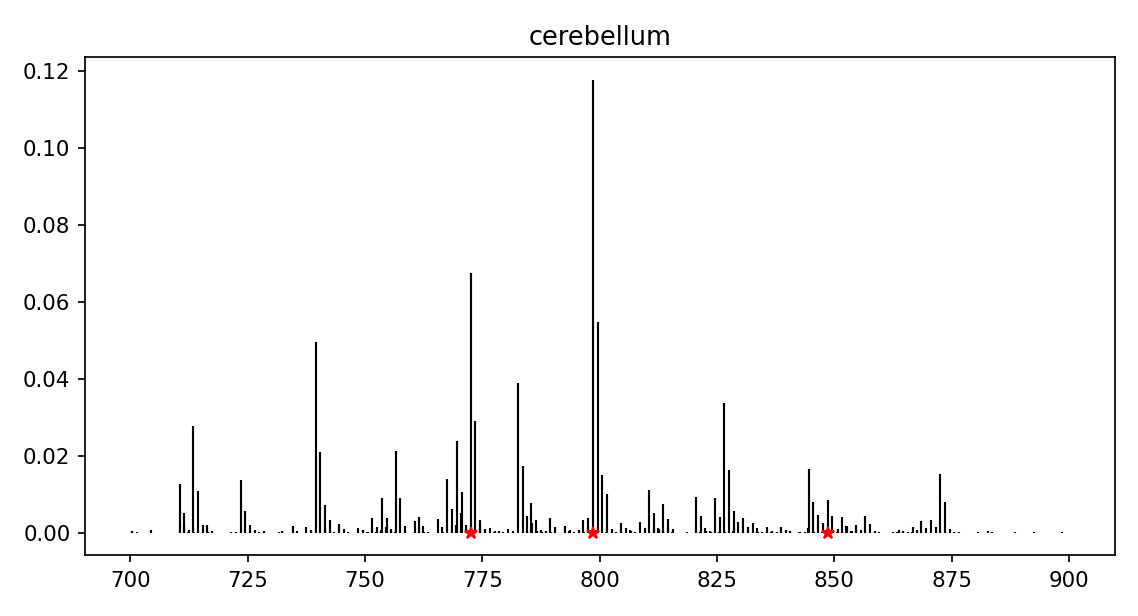

<IPython.core.display.Javascript object>


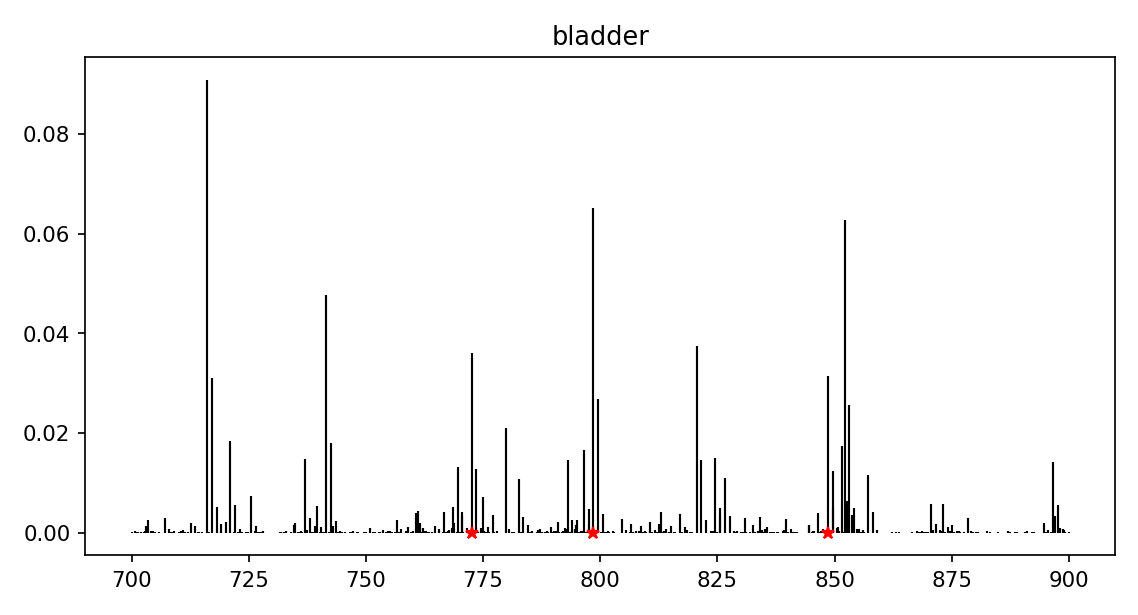

In [13]:
for i, n in enumerate(image_names):
    plt.figure(figsize=(7.4,4))
    plt.title(n)
    average_spectra[n].plot(profile=False, color='k', show=False)
    
    for m in test_lipid_masses:
        plt.plot([m], [0], 'r*')
    plt.tight_layout()
plt.show()

Get the single ion images (from the profile spectrum, so that they're as unprocessed as possible and thus reflect the true distribution as closely as possible)

In [14]:
control_peak_images = {n: np.zeros(image_shapes[n]+(len(test_lipid_spectra), )) for n in image_names}
for i, s in enumerate(test_lipid_spectra):
    mz = s.confs[0][0]
    cer_img = profile_ion_image(cerebellum_profile_image, mz)
    bld_img = profile_ion_image(bladder_profile_image, mz)
    control_peak_images['cerebellum'][...,i] = cer_img
    control_peak_images['bladder'][..., i] = bld_img

Show the ion images to verify correct results

<IPython.core.display.Javascript object>


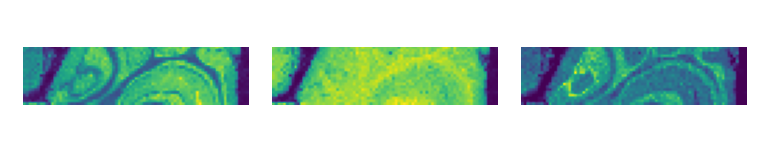

In [15]:
plt.figure(figsize=(5,1))
for i, n in enumerate(test_lipid_spectra):
    plt.subplot(1, len(test_lipid_spectra), 1+i)
    plt.imshow(control_peak_images['cerebellum'][..., i])
    plt.axis('off')
plt.tight_layout()

<IPython.core.display.Javascript object>


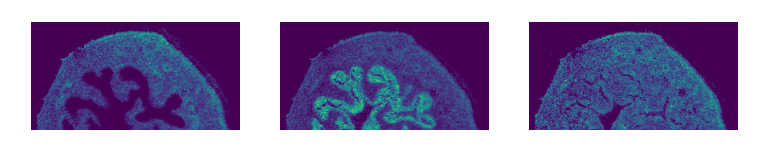

In [16]:
plt.figure(figsize=(5,1))
for i, n in enumerate(test_lipid_spectra):
    plt.subplot(1, len(test_lipid_spectra), 1+i)
    plt.imshow(control_peak_images['bladder'][..., i])
    plt.axis('off')
plt.tight_layout()

Looks good, we have a good selection of different regions of the sample.  

Set a grid of MTD (kappa penalty) values:

In [17]:
mtd_values = np.arange(0.002, 0.03, step=0.002)
mtd_th_values = np.arange(0.002, 0.03, step=0.002)
print(len(mtd_values)*len(mtd_th_values), 'possible combinations')

196 possible combinations


Get samples of pixels for estimation of correlation (deconvolving whole images is unnecessarily computationally expensive)

In [18]:
n_pixels = 1000
fit_masks = {n: np.zeros(image_shapes[n], dtype='bool') for n in image_names}
for n in image_names:
    sampled_pixel_ids = rd.choice(image_shapes[n][0]*image_shapes[n][1], n_pixels, replace=False)
    for pxid in sampled_pixel_ids:
        rowcoord = pxid // image_shapes[n][1]
        colcoord = pxid % image_shapes[n][1]
        fit_masks[n][rowcoord,colcoord] = 1
        

Deconvolve the image for each pair of the MTD parameters and calculate the correlations.  

In [19]:
correlation_heatmaps = {n: np.zeros((len(mtd_values), len(mtd_th_values), len(test_lipid_spectra))) for n in image_names}
for n in image_names:
    print('Processing', n)
    img = centroided_images[n]
    for i, MTD in enumerate(mtd_values):
        for j, MTD_th in enumerate(mtd_th_values):
            # if MTD_th < MTD: continue  
            # print('Checking', MTD, MTD_th)
            deconvolved_images = analyze_image(img, test_lipid_spectra, mask=fit_masks[n],
                                               MTD=MTD, MTD_th = MTD_th, MDC=1e-12, MMD=.5,
                                               verbose=False)
            # Below a manual calculation of the correlation that takes into account
            # the masking - masked pixels are ignored
            for lid in range(len(test_lipid_spectra)):
                masked_control = control_peak_images[n][..., lid]*fit_masks[n]
                deconv = deconvolved_images[..., lid]
                exy = np.sum(deconv*masked_control, axis=(0,1))/n_pixels
                ex = np.sum(deconv, axis=(0,1))/n_pixels
                ey = np.sum(masked_control, axis=(0,1))/n_pixels
                ex2 = np.sum(deconv**2, axis=(0,1))/n_pixels
                ey2 = np.sum(masked_control**2, axis=(0,1))/n_pixels
                covxy = exy - ex*ey
                sdx = np.sqrt(ex2 - ex**2)
                sdy = np.sqrt(ey2 - ey**2)
                correlation_heatmaps[n][i,j, lid] = covxy/(sdx*sdy)

Processing cerebellum
Checking 0.002 0.002
Checking 0.002 0.004
Checking 0.002 0.006
Checking 0.002 0.008
Checking 0.002 0.01
Checking 0.002 0.012
Checking 0.002 0.014
Checking 0.002 0.016
Checking 0.002 0.018000000000000002
Checking 0.002 0.020000000000000004
Checking 0.002 0.022
Checking 0.002 0.024
Checking 0.002 0.026000000000000002
Checking 0.002 0.028000000000000004
Checking 0.004 0.002
Checking 0.004 0.004
Checking 0.004 0.006
Checking 0.004 0.008
Checking 0.004 0.01
Checking 0.004 0.012
Checking 0.004 0.014
Checking 0.004 0.016
Checking 0.004 0.018000000000000002
Checking 0.004 0.020000000000000004
Checking 0.004 0.022
Checking 0.004 0.024
Checking 0.004 0.026000000000000002
Checking 0.004 0.028000000000000004
Checking 0.006 0.002
Checking 0.006 0.004
Checking 0.006 0.006
Checking 0.006 0.008
Checking 0.006 0.01
Checking 0.006 0.012
Checking 0.006 0.014
Checking 0.006 0.016
Checking 0.006 0.018000000000000002
Checking 0.006 0.020000000000000004
Checking 0.006 0.022
Checking 0.0

Checking 0.014 0.026000000000000002
Checking 0.014 0.028000000000000004
Checking 0.016 0.002
Checking 0.016 0.004
Checking 0.016 0.006
Checking 0.016 0.008
Checking 0.016 0.01
Checking 0.016 0.012
Checking 0.016 0.014
Checking 0.016 0.016
Checking 0.016 0.018000000000000002
Checking 0.016 0.020000000000000004
Checking 0.016 0.022
Checking 0.016 0.024
Checking 0.016 0.026000000000000002
Checking 0.016 0.028000000000000004
Checking 0.018000000000000002 0.002
Checking 0.018000000000000002 0.004
Checking 0.018000000000000002 0.006
Checking 0.018000000000000002 0.008
Checking 0.018000000000000002 0.01
Checking 0.018000000000000002 0.012
Checking 0.018000000000000002 0.014
Checking 0.018000000000000002 0.016
Checking 0.018000000000000002 0.018000000000000002
Checking 0.018000000000000002 0.020000000000000004
Checking 0.018000000000000002 0.022
Checking 0.018000000000000002 0.024
Checking 0.018000000000000002 0.026000000000000002
Checking 0.018000000000000002 0.028000000000000004
Checking 0.0

<IPython.core.display.Javascript object>


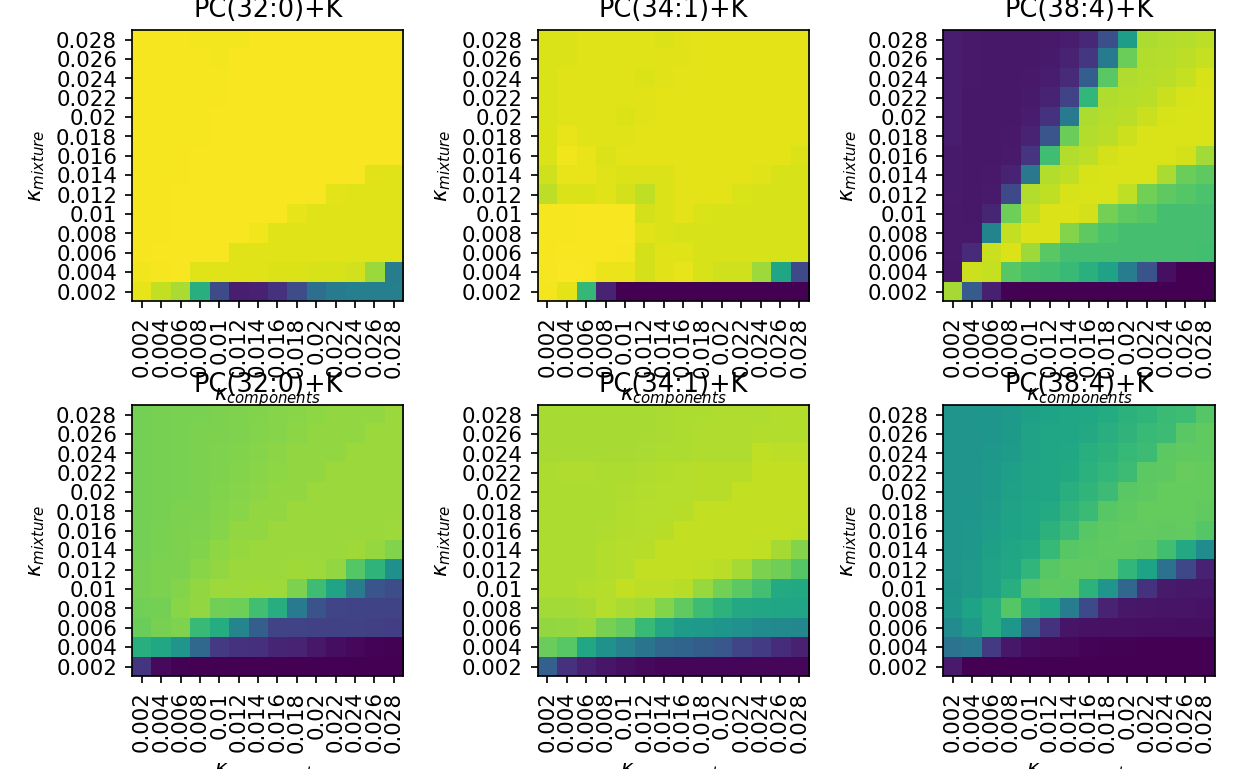

In [29]:
plt.figure(figsize=(8,6))
for i, im_n in enumerate(image_names):
    for j, l_n in enumerate(test_lipid_names):
        plt.subplot(2, 3, 1 + 3*i + j)
        plt.title(l_n)
        plt.imshow(correlation_heatmaps[im_n][::-1, :, j]**10, vmin=0, vmax=1)
        # plt.imshow(1/(correlation_heatmaps[im_n][::-1, :, j]))
        plt.xticks(np.arange(correlation_heatmaps[im_n].shape[1]), np.round(mtd_th_values, 3), rotation=90)
        plt.yticks(np.arange(correlation_heatmaps[im_n].shape[0]), np.round(mtd_values[::-1], 3))
        # if i == len(image_names)-1:
        plt.xlabel('$\kappa_{{components}}$')
        # if j == 0:
        plt.ylabel('$\kappa_{{mixture}}$')
plt.tight_layout()
plt.savefig('Figs/lipid_quantification/correlation_heatmaps_1000pixels_scaled.png', dpi=300)

## Regression settings

Parameters below are selected based on the heatmaps above. They are selected so that there is a relatively broad region of high correlation around the selected values to obtain robust results. At the same time, MTD is kept low to avoid fitting to the background noise.  

In [30]:
MTD = 0.012
MTD_th = 0.016

## Lipid quantification

Estimation through regression on MS images in centroided mode:

In [31]:
# # Masks for testing purposes - to regress only a part of the image
# masks = {n : np.zeros(image_shapes[n]) for n in image_names}
# masks['cerebellum'][5:15, 20:40] = 1
# masks['bladder'][50:90, 50:100] = 1

In [38]:
regression_images = {}
for n in image_names:
    print('Processing', n)
    start = time()
    regression_images[n] = analyze_image(centroided_images[n], lipid_spectra[n],
                                        # mask=masks[n],
                                         MTD=MTD, MTD_th = MTD_th, MDC=1e-12, MMD=1.,
                                         verbose=False)
    end = time()
    print('Processed', n, 'in', end-start, 'seconds')

Processing cerebellum
Processed cerebellum in 321.0463664531708 seconds
Processing bladder
Processed bladder in 3162.366928577423 seconds


Estimation through monoisotopic peak intensity on MS images in profile mode:  
(note: we use profile mode here because centroid mode can lose hidden peaks; profile mode is more accurate; this is more important for peak-based images than for masserstein-based images).

Note: the cell below uses a slow implementation of ion image generating function - it's not vectorized to process multiple m/z values at once.  

In [39]:
single_peak_images = {n: np.zeros(image_shapes[n] + (len(lipid_spectra[n]), )) for n in image_names}
for n in image_names:
    print('Processing', n)
    start = time()
    for i,s in enumerate(lipid_spectra[n]):
        single_peak_images[n][...,i] = profile_ion_image(profile_images[n], s.confs[0][0])
    end = time()
    print('Processed', n, 'in', end-start, 'seconds')

Processing cerebellum
Processed cerebellum in 14.933817148208618 seconds
Processing bladder
Processed bladder in 160.38516569137573 seconds


Check the results:

<IPython.core.display.Javascript object>


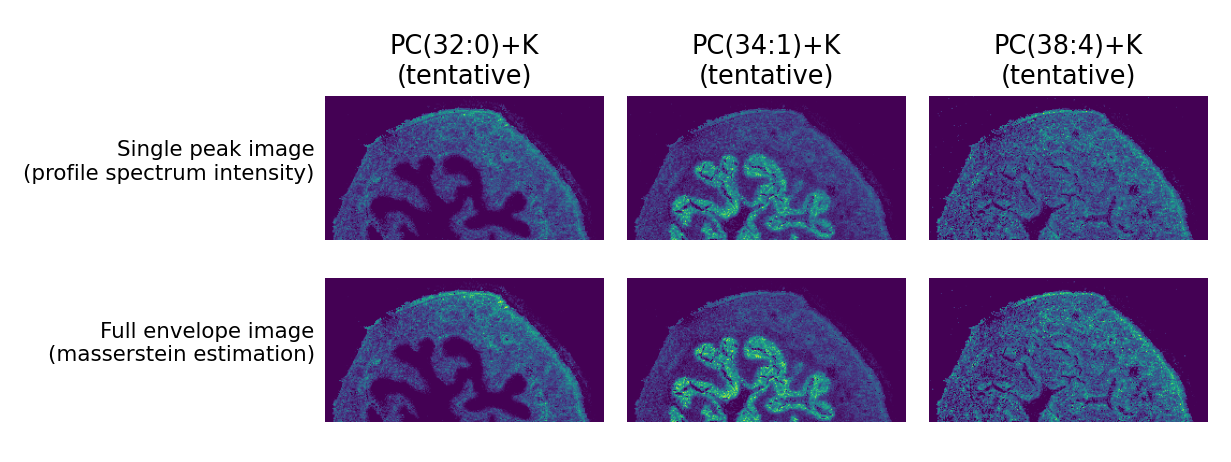

Correlation for PC(32:0)+K 0.9873446614247386
Correlation for PC(34:1)+K 0.9817563311399125
Correlation for PC(38:4)+K 0.9699371314276225


In [50]:
plt.subplots(2, 3, figsize=(8, 3))

for i, lipid_id in enumerate(test_lipid_ids_per_image['bladder']):
    test_masserstein = regression_images['bladder'][...,lipid_id]
    test_intensity = single_peak_images['bladder'][...,lipid_id]
    print('Correlation for', test_lipid_names[i], np.corrcoef(test_masserstein.flatten(), test_intensity.flatten())[0,1])
    plt.subplot(2, 3, 1+i)
    plt.title(test_lipid_names[i] + '\n(tentative)')
    plt.imshow(test_intensity)
    plt.axis('off')
    if i == 0:
        plt.text(-10, 40, 'Single peak image\n(profile spectrum intensity)',
        ha='right',
        va='top')
        
    plt.subplot(2, 3, 4+i)
    plt.imshow(test_masserstein)
    plt.axis('off')
    if i == 0:
        plt.text(-10, 40, 'Full envelope image\n(masserstein estimation)', 
        ha='right',
        va='top')
plt.tight_layout()
plt.savefig('Figs/lipid_quantification/bladder_selected_images.png', dpi=300)

In [ ]:
np.corrcoef(test_masserstein.flatten(), test_intensity.flatten())

<IPython.core.display.Javascript object>


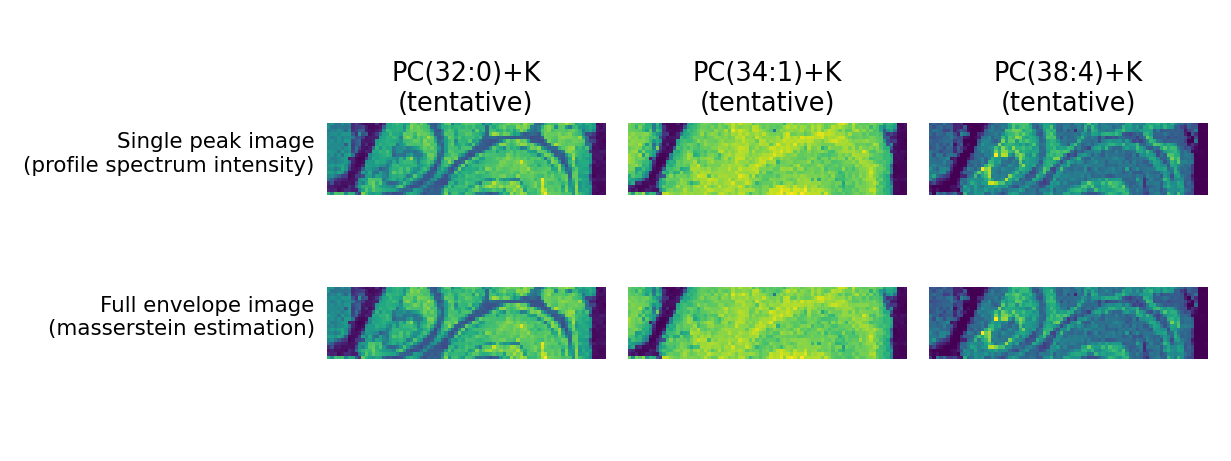

Correlation for PC(32:0)+K 0.999212115258276
Correlation for PC(34:1)+K 0.9984990664829377
Correlation for PC(38:4)+K 0.9963514181030735


In [52]:
plt.subplots(2, 3, figsize=(8, 3))
for i, lipid_id in enumerate(test_lipid_ids_per_image['cerebellum']):
    test_masserstein = regression_images['cerebellum'][...,lipid_id]
    test_intensity = single_peak_images['cerebellum'][...,lipid_id]
    print('Correlation for', test_lipid_names[i], np.corrcoef(test_masserstein.flatten(), test_intensity.flatten())[0,1])
    plt.subplot(2, 3, 1+i)
    plt.title(test_lipid_names[i] + '\n(tentative)')
    plt.imshow(test_intensity)
    plt.axis('off')
    if i == 0:
        plt.text(-4, 2, 'Single peak image\n(profile spectrum intensity)',
        ha='right',
        va='top')
    plt.subplot(2, 3, 4+i)
    plt.imshow(test_masserstein)
    plt.axis('off')
    if i == 0:
        plt.text(-4, 2, 'Full envelope image\n(masserstein estimation)', 
        ha='right',
        va='top')
plt.tight_layout()
plt.savefig('Figs/lipid_quantification/cerebellum_selected_images.png', dpi=300)

## Analyzing the spatial distribution of detected ions

We will do a quick analysis of the spatial distribution in order to detect lipids which are found in less than a given number of pixels. Ions found in only a few pixels are not suitable for segmentation with spatially-aware methods, because they don't have an area of concentration that corresponds to a well-delineated tissue. Therefore, we will use the spatial distribution to refine the annotation of the lipids.   

Inspect the histogram of average estimated proportions of lipids:  

<IPython.core.display.Javascript object>


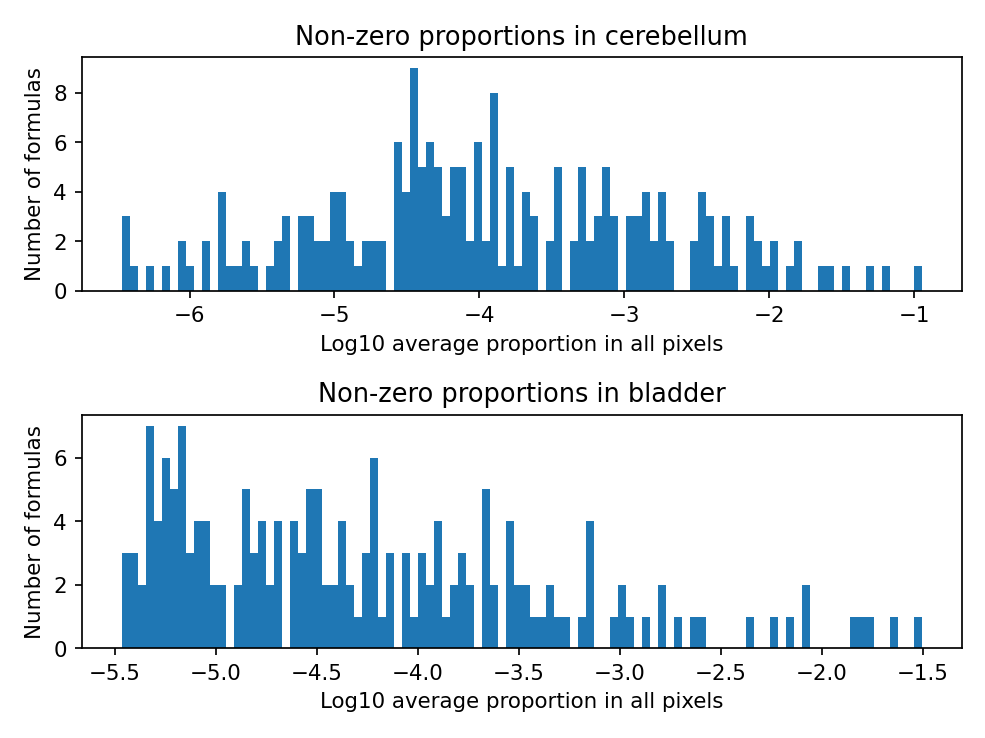

Number of non-zero proportions in cerebellum 209
Number of non-zero proportions in bladder 180


In [54]:
plt.figure()
for i,n in enumerate(image_names):
    plt.subplot(211+i) 
    pvect = regression_images[n].mean(axis=(0,1))
    plt.hist(np.log10(pvect[pvect>0]), bins=100)
    plt.title('Non-zero proportions in ' + n)
    plt.xlabel('Log10 average proportion in all pixels')
    plt.ylabel('Number of formulas')
    print('Number of non-zero proportions in', n, sum(pvect>0))
plt.tight_layout() 
plt.savefig('Figs/lipid_quantification/proportion_histogram.png', dpi=300)

Check the number of pixels with non-zero proportions per lipid:

In [55]:
nonzero_pixel_count = {n: np.array([np.sum(regression_images[n][...,i]>0) for i in range(regression_images[n].shape[2])]) for n in image_names}

<IPython.core.display.Javascript object>


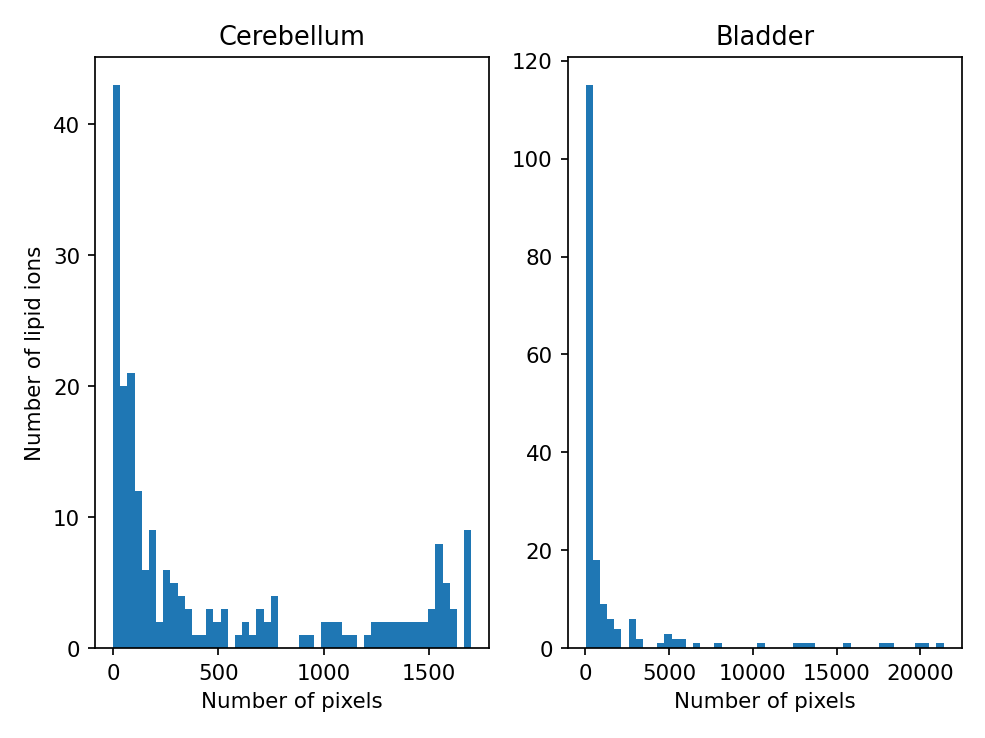

In [59]:
plt.subplots(1,2)
plt.subplot(121)
plt.ylabel('Number of lipid ions')
plt.xlabel('Number of pixels')
plt.title('Cerebellum')
plt.hist(nonzero_pixel_count['cerebellum'], bins=50)
plt.subplot(122)
plt.title('Bladder')
plt.xlabel('Number of pixels')
plt.hist(nonzero_pixel_count['bladder'], bins=50)
plt.tight_layout()
plt.savefig('Figs/lipid_quantification/pixel_histogram.png', dpi=300)

Inspect the histogram of the percentage of observed signal assigned to lipid ions in each pixel:

<IPython.core.display.Javascript object>


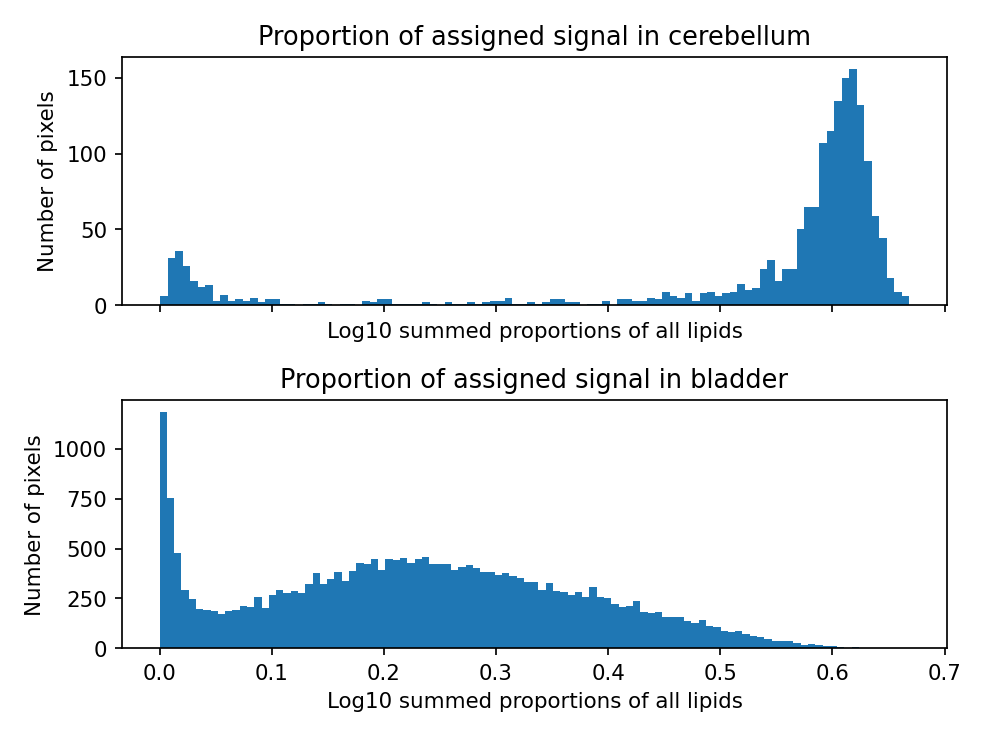

In [65]:
plt.subplots(2,1,sharex=True)
for i,n in enumerate(image_names):
    plt.subplot(211+i) 
    pvect = regression_images[n].sum(axis=2).flatten()
    plt.hist(pvect[pvect>0], bins=100)
    plt.title('Proportion of assigned signal in ' + n)
    plt.xlabel('Log10 summed proportions of all lipids')
    plt.ylabel('Number of pixels')
plt.tight_layout() 
plt.savefig('Figs/lipid_quantification/assigned_signal_histogram.png', dpi=300)

Inspect the correlation between the average proportion and number of non-zero pixels:

<IPython.core.display.Javascript object>


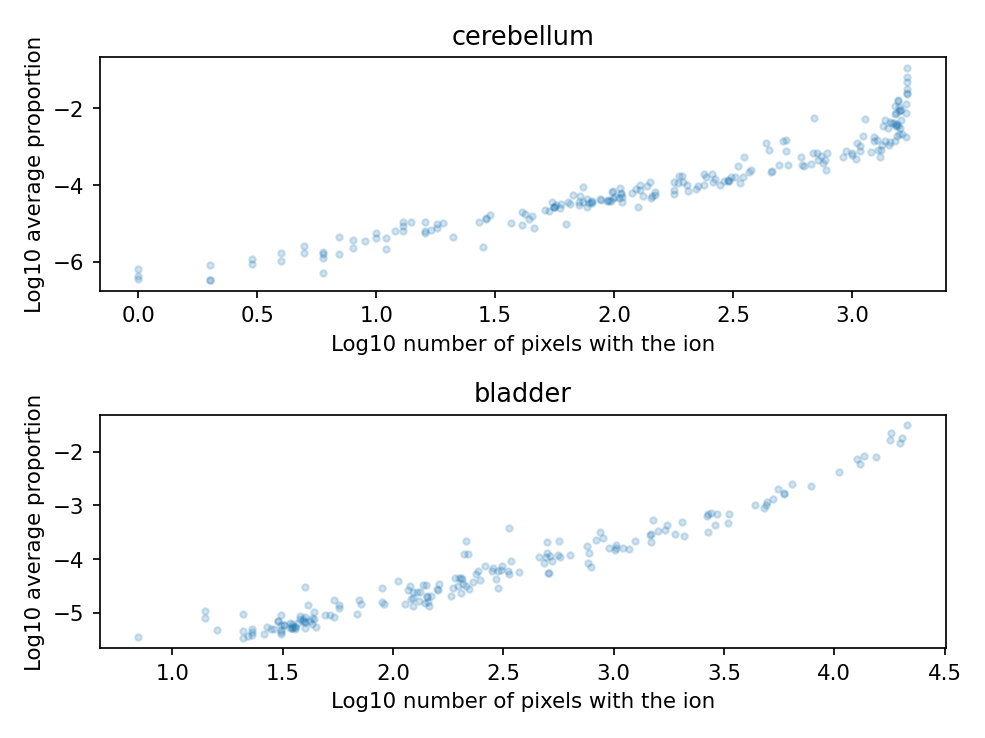

In [68]:
plt.figure()
for i,n in enumerate(image_names):
    plt.subplot(211+i) 
    nvect = (regression_images[n] > 0).sum(axis=(0,1))
    pvect = regression_images[n].mean(axis=(0,1))
    is_present = pvect > 0  # implies nvect > 0
    present_nvect = nvect[is_present]
    present_pvect = pvect[is_present]
    plt.plot(np.log10(present_nvect), np.log10(present_pvect), '.', alpha=0.2)
    plt.title(n)
    plt.xlabel('Log10 number of pixels with the ion')
    plt.ylabel('Log10 average proportion')
plt.tight_layout() 
plt.savefig('Figs/lipid_quantification/proportion_vs_presence.png', dpi=300)

Number of "micro-biomarkers" per image:

In [69]:
for n in image_names:
    print('Lipids in >=20\% pixels in', n, ':', sum(nonzero_pixel_count[n]>=0.2*image_shapes[n][0]*image_shapes[n][1]))
    print('Lipids in >=15\% pixels in', n, ':', sum(nonzero_pixel_count[n]>=0.15*image_shapes[n][0]*image_shapes[n][1]))
    print('Lipids in <=1% of pixels in', n, ':', sum(nonzero_pixel_count[n]<=0.01*image_shapes[n][0]*image_shapes[n][1]))

Lipids in >=20\% pixels in cerebellum : 81
Lipids in >=15\% pixels in cerebellum : 93
Lipids in <=1% of pixels in cerebellum : 34
Lipids in >=20\% pixels in bladder : 11
Lipids in >=15\% pixels in bladder : 16
Lipids in <=1% of pixels in bladder : 114


In [70]:
for n in image_names:
    print('Lipids in >=400 pixels in', n, ':', sum(nonzero_pixel_count[n]>=400))
    print('Lipids in >=300 pixels in', n, ':', sum(nonzero_pixel_count[n]>=300))
    print('Lipids in <=10 of pixels in', n, ':', sum(nonzero_pixel_count[n]<=10))

Lipids in >=400 pixels in cerebellum : 77
Lipids in >=300 pixels in cerebellum : 88
Lipids in <=10 of pixels in cerebellum : 23
Lipids in >=400 pixels in bladder : 65
Lipids in >=300 pixels in bladder : 73
Lipids in <=10 of pixels in bladder : 1


Number of "widespread" lipids per image:

In [71]:
for n in image_names:
    print('Lipids in >=50% of pixels in', n, ':', sum(nonzero_pixel_count[n]>=0.5*image_shapes[n][0]*image_shapes[n][1]))

Lipids in >=50% of pixels in cerebellum : 55
Lipids in >=50% of pixels in bladder : 5


Inspect lipids found in a given number of pixels in order to identify an appropriate threshold of the number of pixels above which lipids are suitable for quantification.  

In [95]:
# We'll select a few lipids which are found in a number of pixels between nb_low and nb_up. 
nb_low = 400 # minimum number of pixels 
nb_up = 1200  # maximum number of pixels
matching_lipids = {}
for n in image_names:
    matching_lipids[n] = [i for i,pxc in enumerate(nonzero_pixel_count[n]) if nb_low <= pxc <= nb_up]
# matching_lipids

<IPython.core.display.Javascript object>


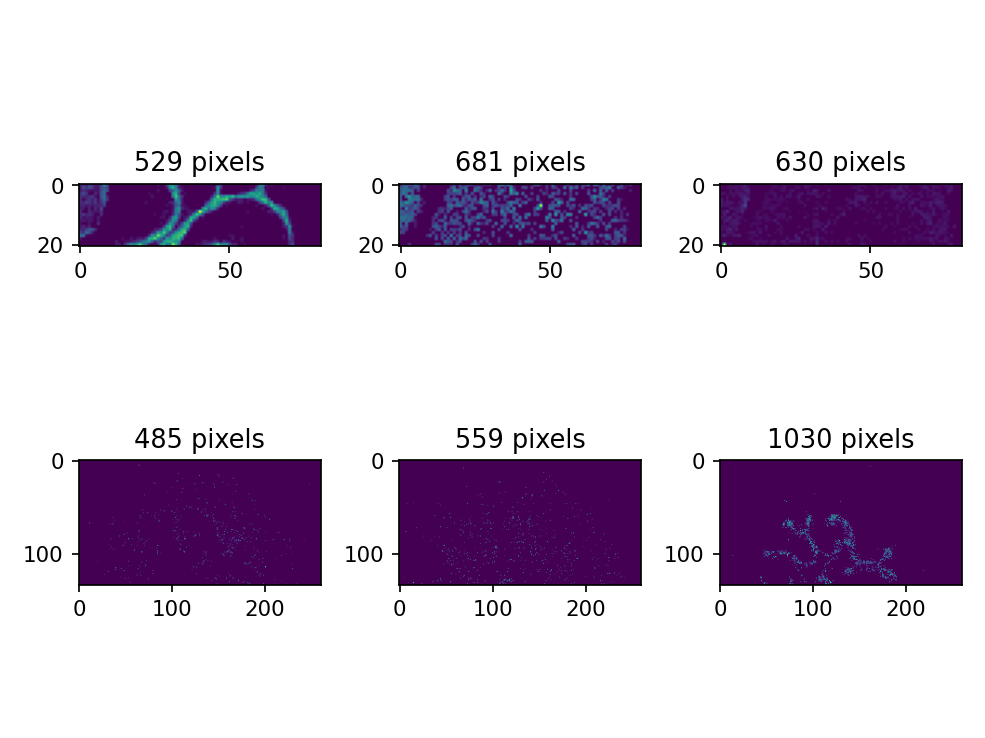

In [96]:
plt.figure()
for i, im_n in enumerate(image_names):
    for j, lid in enumerate(rd.choice(matching_lipids[im_n], 3, replace=False)):
        plt.subplot(2, 3, 1 + 3*i + j)
        plt.title(str(nonzero_pixel_count[im_n][lid]) + ' pixels')
        plt.imshow(regression_images[im_n][...,lid])
plt.tight_layout()

The threshold of 400 pixels seems good enough for the cerebellum - we can see the structures clearly.  
It's not good enough for the bladder - the structures are barely visible and don't seem fit for a spatially-aware segmentation. Therefore, we'll increase the threshold to 700.  

In [14]:
pixel_thresholds = {'cerebellum': 400, 'bladder': 1000}

In [92]:
for n in image_names:
    print(sum(nonzero_pixel_count[n]>pixel_thresholds[n]), 'lipids pass the threshold')

77 lipids pass the threshold
44 lipids pass the threshold


## Saving the results

Save the estimation results as numpy matrices:

In [97]:
regression_images['cerebellum'].dump('cerebellum_regression_images.dmp')
regression_images['bladder'].dump('bladder_regression_images.dmp')

Save the estimation results as numpy matrices:

In [98]:
single_peak_images['cerebellum'].dump('cerebellum_single_peak_images.dmp')
single_peak_images['bladder'].dump('bladder_single_peak_images.dmp')

Save the refined annotation:

In [106]:
for i,n in enumerate(image_names):
    with open(n + '_refined_annotation_results.tsv', 'w') as h:
        props = regression_images[n].mean(axis=(0,1))
        pix = (regression_images[n] > 0).sum(axis=(0,1))
        det = pix > pixel_thresholds[n]
        # Write the header
        h.write('\t'.join(['Formula', 'Mass', 'Average proportion', 'Number of pixels', 'Suitable for segmentation']) + '\n')
        
        # Write the annotated formulas with their initially estimated proportions
        for l_id, s, p, px, d in zip(range(len(lipid_spectra[n])), lipid_spectra[n], props, pix, det):
            mz = round(s.confs[0][0], 4)
            p = round(p, 4)
            h.write('\t'.join([s.formula, str(mz), str(p), str(px), str(d)]) + '\n')

Save the deconvolved ion images:

In [23]:
for i, n in enumerate(image_names):
    pix = (regression_images[n] > 0).sum(axis=(0,1))
    det = pix > pixel_thresholds[n]
    
    deconv_img = regression_images[n][..., det]
    mass_axis = [s.confs[0][0] for s, t in zip(lipid_spectra[n], det) if t]
    mass_axis_order = sorted(range(len(mass_axis)), key = lambda i: mass_axis[i])
    sorted_mass_axis = [mass_axis[i] for i in mass_axis_order]
    
    with ImzMLWriter('%s_deconvolved_image.imzML' % n) as writer:
        for i in range(image_shapes[n][0]):
            for j in range(image_shapes[n][1]):
                sorted_intensity = [deconv_img[i,j,iid] for iid in mass_axis_order]
                writer.addSpectrum(sorted_mass_axis, sorted_intensity, (j, i))

In [13]:
regression_images = {n : np.load(n+'_regression_images.dmp', allow_pickle=True) for n in image_names}
[regression_images[n].shape for n in image_names]

[(21, 81, 209), (134, 260, 180)]

In [ ]:
spectrum_of_interest = min(lipid_spectra['cerebellum'], key = lambda x: x.confs[0][0])
    with ImzMLWriter('%s_deconvolved_image.imzML' % n) as writer:
        for i in range(image_shapes[n][0]):
            for j in range(image_shapes[n][1]):
                sorted_intensity = [deconv_img[i,j,iid] for iid in mass_axis_order]
                writer.addSpectrum(sorted_mass_axis, sorted_intensity, (j, i))

In [18]:
spectrum_of_interest = min(zip(lipid_spectra['cerebellum'], range(len(lipid_spectra['cerebellum']))), key = lambda x: abs(x[0].confs[0][0]-755.47))

In [25]:
n='cerebellum'
mz = spectrum_of_interest[0].confs[0][0]
lid = spectrum_of_interest[1]
with ImzMLWriter('test_image.imzML') as writer:
    for i in range(image_shapes[n][0]):
        for j in range(image_shapes[n][1]):
            writer.addSpectrum([mz], [regression_images['cerebellum'][i,j,lid]], (j, i))

In [24]:
lid

35